Mounting my google drive to retrieve dataset:

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
folder_path = '/content/drive/My Drive/'
os.chdir(folder_path)

Mounted at /content/drive


Code for reading dataset as .csv file.

In [1]:
import pandas as pd
import numpy as np

# Read the CSV file into a DataFrame
file_names = ['large_dataset.csv']
dfs = [pd.read_csv('./data/'+example) for example in file_names]

# Initialize an empty list to store the transformed data
train_dataset = []

# Iterate through the rows of the DataFrame
# prefixing in urdu
for df in dfs:
  for index, row in df.iterrows():
      input_text = "جملے کی درستگی: " + row['X']
      output_text = input_text + ' ' + 'درست جملہ: ' + row['Y']

      # Create a dictionary for each example and append it to the train_dataset
      example = {"input": input_text, "output": output_text}
      train_dataset.append(example)
      #print(example)

print(train_dataset[len(train_dataset)-1])
np.random.shuffle(train_dataset)
len(train_dataset)

{'input': 'جملے کی درستگی: بھائی جان بڑے دعوے سے کہتے ہے کہ یہ ایک عالمی ریکارڈ ہے۔', 'output': 'جملے کی درستگی: بھائی جان بڑے دعوے سے کہتے ہے کہ یہ ایک عالمی ریکارڈ ہے۔ درست جملہ: بھائی جان بڑے دعوے سے کہتے ہیں کہ یہ ایک عالمی ریکارڈ ہے۔'}


36808

Loading model using Pytorch:

In [3]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import tensorflow as tf

#model_path = "hadidev/gpt2-urdu-smallest"
#path will be different each time as I'm saving it based on current datetime
model_path = "./finetuned_gpt2l_model_prefixed"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path, ignore_mismatched_sizes=True, from_tf=True)

# Extend the vocabulary to include [PAD] token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))



2023-12-08 16:08:27.641644: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: JIT compilation failed.


UnknownError: Exception encountered when calling layer 'ln_1' (type LayerNormalization).

{{function_node __wrapped__Rsqrt_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Rsqrt] name: 

Call arguments received by layer 'ln_1' (type LayerNormalization):
  • inputs=tf.Tensor(shape=(1, 2, 768), dtype=float32)

In [ ]:
batch_size = 128
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

Training model

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer
from transformers import AdamW
from tqdm import tqdm
import torch.nn.functional as F
import csv
from datetime import datetime
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler
import os

# Define optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

batch_size = 2
# Gradient accumulation
accumulation_steps = 4  # Accumulate gradients over 4 batches before updating

# Gradient clipping
max_grad_norm = 1.0  # Set your desired maximum gradient norm

# Mixed-precision training
scaler = GradScaler()

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}


# def train(train_dataloader):
    # global model
    # global optimizer
    # global scheduler
    # global scaler
    # global accumulation_steps
    # global max_grad_norm

    # total_loss = 0
    # correct_train_predictions = 0
    # total_train_samples = 0

    # for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
    #     inputs = batch[0]["input_ids"]
    #     labels = batch[1]["input_ids"]

    #     max_length = max(inputs.size(1), labels.size(1))
    #     inputs = F.pad(inputs, (0, max_length - inputs.size(1)))
    #     labels = F.pad(labels, (0, max_length - labels.size(1)))

    #     optimizer.zero_grad()

    #     with autocast():  # Use mixed-precision training
    #         outputs = model(inputs, labels=labels)
    #         logits = outputs.logits

    #         loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=tokenizer.pad_token_id)

    #     scaler.scale(loss).backward()

    #     if (i + 1) % accumulation_steps == 0:
    #         scaler.unscale_(optimizer)  # Unscales the gradients of optimizer's assigned params in-place
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping
    #         scaler.step(optimizer)
    #         scaler.update()
    #         optimizer.zero_grad()

    #     total_loss += loss.item()

    #     _, predicted_labels = torch.max(logits, dim=-1)
    #     correct_train_predictions += torch.sum(predicted_labels.view(-1) == labels.view(-1)).item()
    #     total_train_samples += labels.numel()

    # return total_train_samples, total_loss, correct_train_predictions


def train(train_dataloader):
    global model
    global optimizer
    global scheduler

    total_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        inputs = batch[0]["input_ids"]
        labels = batch[1]["input_ids"]

        max_length = max(inputs.size(1), labels.size(1))
        inputs = F.pad(inputs, (0, max_length - inputs.size(1)))
        labels = F.pad(labels, (0, max_length - labels.size(1)))

        optimizer.zero_grad()

        outputs = model(inputs, labels=labels)
        logits = outputs.logits

        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=tokenizer.pad_token_id)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=-1)
        correct_train_predictions += torch.sum(predicted_labels.view(-1) == labels.view(-1)).item()
        total_train_samples += labels.numel()

    return total_train_samples, total_loss, correct_train_predictions


def validate(validation_dataloader):
    global model

    total_samples = 0
    val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for val_batch in validation_dataloader:
            val_inputs = val_batch[0]["input_ids"]
            val_labels = val_batch[1]["input_ids"]

            max_length = max(val_inputs.size(1), val_labels.size(1))
            val_inputs = F.pad(val_inputs, (0, max_length - val_inputs.size(1)))
            val_labels = F.pad(val_labels, (0, max_length - val_labels.size(1)))

            val_outputs = model(val_inputs, labels=val_labels)
            val_logits = val_outputs.logits

            val_loss += F.cross_entropy(val_logits.view(-1, val_logits.size(-1)), val_labels.view(-1), ignore_index=tokenizer.pad_token_id).item()

            _, predicted_labels = torch.max(val_logits, dim=-1)
            correct_predictions += torch.sum(predicted_labels.view(-1) == val_labels.view(-1)).item()
            total_samples += val_labels.numel()

    return total_samples, val_loss, correct_predictions


def initialize_data(start, end):
    global train_dataset

    input_texts = [example["input"] for example in train_dataset[start:end]]
    target_texts = [example["output"] for example in train_dataset[start:end]]

    # train validation split
    split_ratio = 0.9
    train_size = int(split_ratio * len(input_texts))
    indices = np.arange(len(input_texts))
    np.random.shuffle(indices)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_input_texts = [input_texts[i] for i in train_indices]
    train_target_texts = [target_texts[i] for i in train_indices]
    validation_input_texts = [input_texts[i] for i in val_indices]
    validation_target_texts = [target_texts[i] for i in val_indices]

    # custom datasets
    train_input_dataset = CustomDataset(train_input_texts, tokenizer)
    train_target_dataset = CustomDataset(train_target_texts, tokenizer)
    validation_input_dataset = CustomDataset(validation_input_texts, tokenizer)
    validation_target_dataset = CustomDataset(validation_target_texts, tokenizer)

    # Combine datasets for DataLoader
    train_combined_dataset = list(zip(train_input_dataset, train_target_dataset))
    train_dataloader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)
    validation_combined_dataset = list(zip(validation_input_dataset, validation_target_dataset))
    validation_dataloader = DataLoader(validation_combined_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, validation_dataloader


# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
iterations = 1

for i in range(0, iterations):
    num_epochs = 15
    start_index = 2000
    end_index = 5000
    train_dataloader, validation_dataloader = initialize_data(start_index, end_index)

    for epoch in range(num_epochs):
        total_train_samples, total_loss, correct_train_predictions = train(train_dataloader)
        scheduler.step()

        #validation
        total_samples, val_loss, correct_predictions = validate(validation_dataloader)

        # Metrics
        average_train_loss = total_loss / len(train_dataloader)
        average_val_loss = val_loss / len(validation_dataloader)

        accuracy = correct_predictions / total_samples
        accuracy_train = correct_train_predictions / total_train_samples

        train_losses.append(average_train_loss)
        val_losses.append(average_val_loss)

        val_accuracies.append(accuracy)
        train_accuracies.append(accuracy_train)

        print(f"Train Loss: {average_train_loss}, Train accuracy: {accuracy_train}, Val Loss: {average_val_loss}, Val Accuracy: {accuracy}")

name = "./finetuned_gpt2l_model_prefixed"
model.save_pretrained(name)
tokenizer.save_pretrained(name)
print("Saved as ", name)

Epoch 1: 100%|██████████| 1350/1350 [06:01<00:00,  3.73it/s]


Train Loss: 2.5177998533141284, Train accuracy: 0.21157407407407408, Val Loss: 2.238738141854604, Val Accuracy: 0.21721354166666668


Epoch 2: 100%|██████████| 1350/1350 [06:01<00:00,  3.74it/s]


Train Loss: 1.8631185537217945, Train accuracy: 0.23395833333333332, Val Loss: 1.995892565647761, Val Accuracy: 0.22669270833333333


Epoch 3: 100%|██████████| 1350/1350 [06:00<00:00,  3.75it/s]


Train Loss: 1.5504119277414348, Train accuracy: 0.248359375, Val Loss: 1.8440240387370188, Val Accuracy: 0.234296875


Epoch 4: 100%|██████████| 1350/1350 [06:00<00:00,  3.75it/s]


Train Loss: 1.3659975282803902, Train accuracy: 0.2568229166666667, Val Loss: 1.778567458987236, Val Accuracy: 0.23815104166666667


Epoch 5: 100%|██████████| 1350/1350 [06:00<00:00,  3.75it/s]


Train Loss: 1.2665003344916772, Train accuracy: 0.26201099537037037, Val Loss: 1.729025723139445, Val Accuracy: 0.24059895833333333


Epoch 6: 100%|██████████| 1350/1350 [06:00<00:00,  3.75it/s]


Train Loss: 1.22013073696729, Train accuracy: 0.2647974537037037, Val Loss: 1.7292604722579321, Val Accuracy: 0.24190104166666668


Epoch 7: 100%|██████████| 1350/1350 [06:00<00:00,  3.75it/s]


Train Loss: 1.1810779749981508, Train accuracy: 0.2662326388888889, Val Loss: 1.6868604801098506, Val Accuracy: 0.242734375


Epoch 8: 100%|██████████| 1350/1350 [06:00<00:00,  3.75it/s]


Train Loss: 1.1700747150707886, Train accuracy: 0.26699652777777777, Val Loss: 1.6905726604660352, Val Accuracy: 0.24278645833333334


Epoch 9: 100%|██████████| 1350/1350 [06:00<00:00,  3.74it/s]


Train Loss: 1.173806082800686, Train accuracy: 0.267349537037037, Val Loss: 1.7089297466476758, Val Accuracy: 0.24263020833333335


Epoch 10: 100%|██████████| 1350/1350 [06:00<00:00,  3.74it/s]


Train Loss: 1.1640315686925142, Train accuracy: 0.2674797453703704, Val Loss: 1.694416165749232, Val Accuracy: 0.24294270833333334


Epoch 11: 100%|██████████| 1350/1350 [06:01<00:00,  3.74it/s]


Train Loss: 1.1541907719549447, Train accuracy: 0.26763888888888887, Val Loss: 1.71001863916715, Val Accuracy: 0.24286458333333333


Epoch 12: 100%|██████████| 1350/1350 [06:01<00:00,  3.74it/s]


Train Loss: 1.1606061477834118, Train accuracy: 0.2676736111111111, Val Loss: 1.7068983056458333, Val Accuracy: 0.24283854166666666


Epoch 13: 100%|██████████| 1350/1350 [06:01<00:00,  3.73it/s]


Train Loss: 1.160948121096956, Train accuracy: 0.2676938657407407, Val Loss: 1.7006645475824673, Val Accuracy: 0.242890625


Epoch 14: 100%|██████████| 1350/1350 [06:01<00:00,  3.74it/s]


Train Loss: 1.1615758402953442, Train accuracy: 0.2676996527777778, Val Loss: 1.679836516181628, Val Accuracy: 0.24291666666666667


Epoch 15:  12%|█▏        | 156/1350 [00:41<05:19,  3.73it/s]

Plotting:

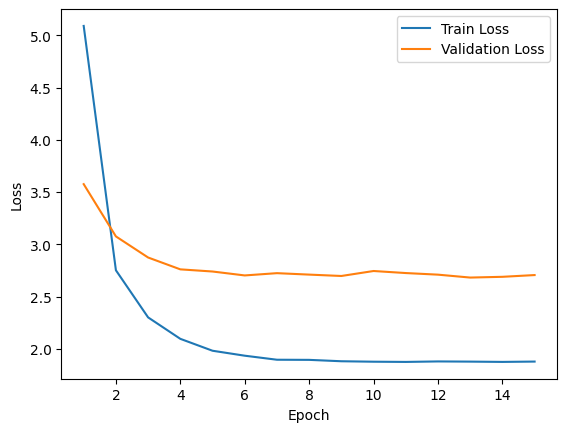

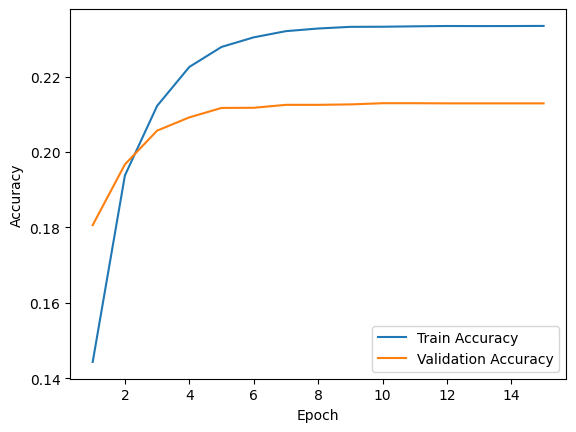

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs*iterations + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs*iterations + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Saving Model

Testing model

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


input_sentences = [
                    'اس نے گھر جانا ہے',
                   'آپ کو تار ملی',
                   'آپ کی قلم کہاں ہے',
                   'غصّہ سے اس کا چہرہ سرخ ہوگيا',
                   'امی ابو گھر پر نہیں ہے',
                   'طارق نے اخبار خریدی',
                   'مین جارہا تھی',
                   ]

model.config.pad_token_id = tokenizer.eos_token_id

for input_sentence in input_sentences:
    print("جملے کی درستگی: " + input_sentence)
    input_ids = tokenizer.encode("جملے کی درستگی: " + input_sentence, return_tensors="pt", max_length=128, truncation=True).to(device)
    attention_mask = torch.ones(input_ids.shape, device=input_ids.device)
    output_ids = model.generate(input_ids, max_length=128, num_beams=3, num_return_sequences=3, attention_mask=attention_mask)
    for output_id in output_ids:
      corrected_sentence = tokenizer.decode(output_id, skip_special_tokens=True)
      print(f"{corrected_sentence}")
    print("")

جملے کی درستگی: اس نے گھر جانا ہے


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


جملے کی درستگی اس نے گھر جانا ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے
جملے کی درستگی اس نے گھر جانا ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے� ہے ہے ہے ہے ہے
جملے کی درستگی اس نے گھر جانا ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے 